In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for park and ride paths
## Needs the road network, PT network and all connectors

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [ ]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [3]:
sm = stepmodel.read_json(input_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')
z = stepmodel.read_json(model_path + 'de_zones')
pt = stepmodel.read_json(model_path + 'de_pt_network_agg')
pt_ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

In [4]:
sm.zone_to_road = ae.zone_to_road
sm.road_to_transit = ae.road_to_transit
sm.centroids = ae.centroids
sm.zones = z.zones
sm.links = pt.links
sm.nodes = pt.nodes # Must have a boolean column "parking_spots"
sm.zone_to_transit = pt_ae.zone_to_transit
sm.footpaths = pt_ae.footpaths

## Prepare networks
The maxspeed column of the road links is based on OSM data that needs to be refined. The unit is km/h

In [ ]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [ ]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits
road_speed_calibration = params['car']['speed_calibration']
sm.road_links["time"] = sm.road_links["length"] / 1000 / \
    (sm.road_links["maxspeed"] * road_speed_calibration) * 3600

In [ ]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [ ]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

### Alter road access/egress links

In [16]:
# Assign a time to access the car
sm.zone_to_road['time'] = params['access-egress_links']['time_road']

In [ ]:
# Assign a time to change between car and PT
sm.road_to_transit['time'] = params['access-egress_links']['time_road_pt']

## Apply P&R pathfinder in order to generate LoS table

In [17]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [18]:
sm.step_pr_pathfinder(od_set=od_set)

In [19]:
sm.pr_los.sample(3)

,origin,destination,time,path,node_path,link_path,ntlegs
155082,DEG0A,DEB13,16201.0,"[DEG0A, 1722581330, 1721505483, 929943627, 151...","[1722581330, 1721505483, 929943627, 15164786, ...","[rl_413985, rl_446702, rl_477985, rl_345566, r...","[(DEG0A, 1722581330), (307762151, DEB13)]"
150677,DEF0D,DEB1B,21734.0,"[DEF0D, 25076702, 25076790, 5730788622, 216996...","[25076702, 25076790, 5730788622, 21699647, 280...","[rl_462544, rl_429089, rl_204552, rl_462619, r...","[(DEF0D, 25076702), (1765034897, DEB1B)]"
58320,DE405,DE71E,23157.0,"[DE405, 1455170487, 2343331268, 29353517, 2935...","[1455170487, 2343331268, 29353517, 29353512, 3...","[rl_419589, rl_487756, rl_487754, rl_386938, r...","[(DE405, 1455170487), (3251511786, DE71E)]"


In [20]:
sm.pr_los.shape

(160801, 7)

In [23]:
# Drop inner-cell connections
sm.pr_los = sm.pr_los[pr_los['time']!=0]
sm.pr_los.shape

(160400, 7)

## Add various attributes to LoS table

In [24]:
# Disaggregate into in-vehicle time and access/egress
sm.analysis_car_time()
sm.pr_los.columns

Index(['origin', 'destination', 'time', 'path', 'node_path', 'link_path',
       'ntlegs', 'access_time', 'in_vehicle_time'],
      dtype='object')


In [25]:
# Add distances car
len_dict = sm.road_links['length'].to_dict()
sm.pr_los['length'] = sm.pr_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))
assert False # Add PT length??

In [26]:
# Add route_type = 'car' in car_los
sm.analysis_car_route_type()
assert False

In [27]:
assert False
sm.pr_los['ntransfers'] = 0

## Add cost to LoS table

In [29]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [31]:
# Prep
sm.pr_los['price'] = 0
vc_car = params['car']['var_cost']
fix_car = params['car']['fix_cost']
parking_cost = params['parking_cost']
car_occ = params['car']['occupancy']

1.551890814081408
0.00011439257425742574


In [32]:
urb_dict = sm.zones['urbanisation'].to_dict()
sm.pr_los['price'] = sm.pr_los.apply(lambda df: monetary_cost(
    df['length'], 1, vc_car,
    0,0, # parking at home is for free
    parking_cost[urb_dict[df['destination']]], 1,
    car_occ) + fix_car, axis=1)
assert False

In [33]:
sm.pr_los.sample(2)

,origin,destination,time,path,node_path,link_path,ntlegs,access_time,in_vehicle_time,length,route_types,route_type,ntransfers,accessibility,price
37461,DE245,DE717,9945,"[DE245, 306268450, 306253393, 480638786, 30626...","[306268450, 306253393, 480638786, 306264403, 4...","[rl_53660, rl_44462, rl_247282, rl_51273, rl_2...","[(DE245, 306268450), (848510869, DE717)]",600,9345,231429,"(car,)",car,0,1,19.201064
48672,DE268,DE40B,16257,"[DE268, 857381969, 2428188565, 262558486, 2428...","[857381969, 2428188565, 262558486, 2428188596,...","[rl_396698, rl_135586, rl_262099, rl_396709, r...","[(DE268, 857381969), (1607014826, DE40B)]",600,15657,397068,"(car,)",car,0,1,31.832978


<AxesSubplot:xlabel='length', ylabel='price'>

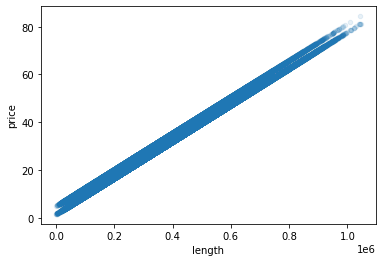

In [34]:
sm.pr_los.plot.scatter(x='length', y='price', alpha=.1)

## Save model

In [37]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.pr_los = sm.pr_los.drop(to_drop, axis=1, errors='ignore')

In [38]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.pr_los[cols] = sm.pr_los[cols].astype(int)

In [39]:
sm.to_json(model_path + 'de_pr_los',
           only_attributes=['pr_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.19it/s]
